- Carefull to use renormalized Legendre polynomials and not the normal ones

- https://arxiv.org/pdf/2210.10942.pdf for the computations of the normalization constant

- add the running time to make light of the fact a large condition number is a pain?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 1/(25*x**2+1)

In [3]:
def Markov(M, f, seed):
    np.random.seed(seed) #for reproducibility
    true_val=np.arctan(5)/5
    
    X=np.random.uniform(size=M)
    
    f_array=np.array([f(x) for x in X])
    est_value=np.mean(f_array)
    
    return np.abs(est_value-true_val)

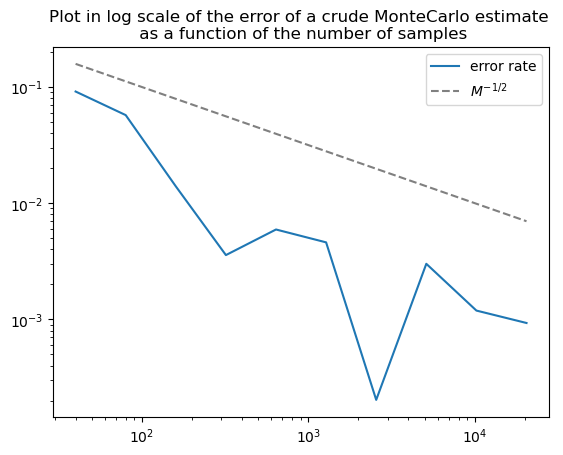

In [10]:
seed=9001 #for reproducibility

M_array= np.array([20*2**i for i in range(1,11)])

error_function=np.array([Markov(m, f, seed) for m in M_array])

plt.loglog(M_array, error_function, label='error rate')
plt.loglog(M_array, M_array**-0.5, '--', label = r'$M^{-1/2}$',color='gray')
plt.title("Plot in log scale of the error of a crude MonteCarlo estimate \n as a function of the number of samples")
plt.xlabel("Number of samples")
plt.ylabel("Estimation error")
plt.legend()
plt.savefig("Figures/MC_crude.png")
plt.show()

*Comment*: Looks nice, converges with rate M^{-0.5} as states the theory

#### Part b)

*Comment*: After hesitating between using scipy and numpy, choosing numpy

In [5]:
import numpy.polynomial.legendre as L

In [6]:
def degree(n):
    if n!=0:
        list_=[0]*(n+1)
        list_[-1]=1
        return list_
    if n==0:
        return [1,0] #small fix, [1,0] is equivalent to [1] but they didn't like [1]

In [7]:
def V_mat(M, N, X):
    V=np.ones((M,N+1))
    for i in range(1,N+1):
        l_i=np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0,1]) #normalization coefficient to ensure orthonormality of
        #Legendre polynomials 
        V[:,i]=[l_i(x) for x in X]
    return V, np.linalg.cond(V)

In [8]:
def coefficient(M, N, seed):
    np.random.seed(seed) #for reproducibility
    X=np.random.uniform(size=M)
    V, cond_V=V_mat(M, N, X)
    f_eval=np.array([f(x) for x in X])
    c_coeff,_,_,_=np.linalg.lstsq(V,f_eval, rcond=10**(-5))
    return c_coeff, cond_V

In [9]:
def IMCLS(M, N, seed_1, seed_2):
    
    np.random.seed(seed_1)
    X=np.random.uniform(size=M)
    c_coeff, cond_V=coefficient(M, N, seed_2)
    l_array=lambda x,n: np.array([np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0,1])(x) for j in range(0,n+1)])
    f_array=np.array([f(x)-c_coeff@l_array(x, N) for x in X])
    
    IMCLS_value=np.mean(f_array)+c_coeff[0]
    IMCLS_prime_val=c_coeff[0]
    true_val=np.arctan(5)/5
    
    return np.abs(IMCLS_value-true_val), np.abs(true_val-IMCLS_prime_val), cond_V

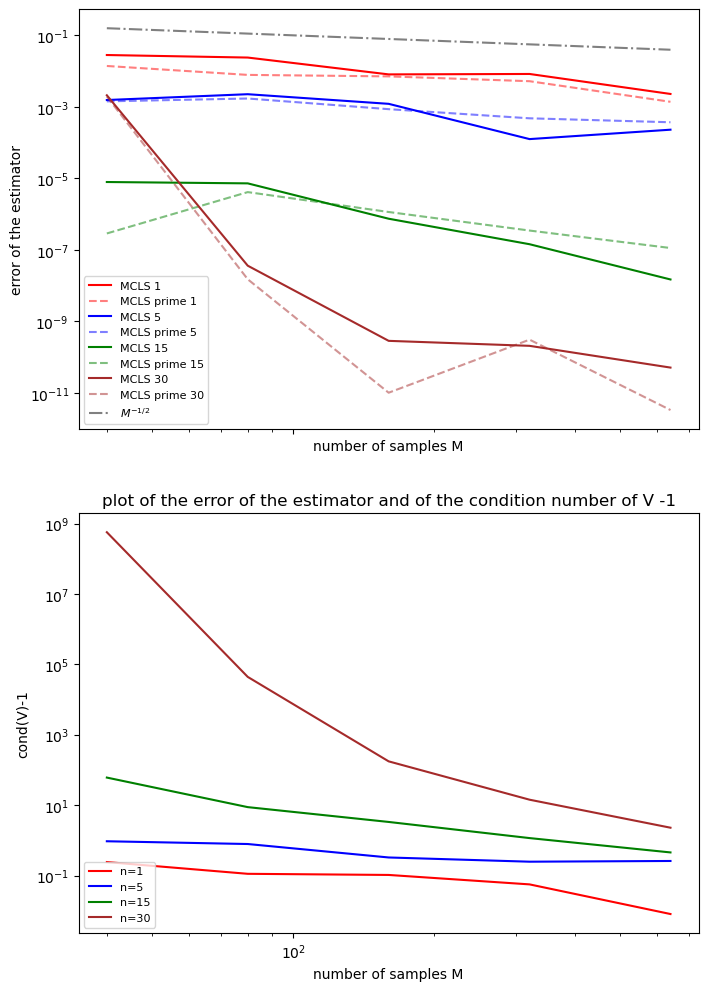

In [21]:
#all estimators have the same seed so that their performance doesn't depend on the sample drawn

fig, ax = plt.subplots(2,figsize= (8,12), sharey = False, sharex = True)

N=[1,5, 15, 30] #change to [1,5, 15, 30]
M_array=np.array([20*2**i for i in range(1,6)]) #modify to (1,8) during the night??

seed_1=9009
seed_2=1991

sbplt_0 = ax[0] #plot of the estimators
sbplt_1 = ax[1] #plot of the condition number
c=['red','blue', 'green', 'brown'] 
for i, n in enumerate(N):
    error_function_IMCLS=[]
    error_function_IMCLS_prime=[]
    cond_V=[]
    
    for m in M_array:
        e_IMCLS, e_IMCLS_prime, c_v=IMCLS(m, n, seed_1, seed_2)
        cond_V.append(c_v-1)
        error_function_IMCLS.append(e_IMCLS)
        error_function_IMCLS_prime.append(e_IMCLS_prime)
           
    sbplt_0.loglog(M_array,error_function_IMCLS, color=c[i], label="MCLS "+str(n))
    sbplt_0.loglog(M_array,error_function_IMCLS_prime, alpha=0.5, color=c[i], linestyle='--', label="MCLS prime "+str(n))
    sbplt_1.loglog(M_array, cond_V, color=c[i], label='n='+str(n))
    sbplt_1.set_title("(Condition number of V)-1 versus the number of samples")

#ploting O(M^{-1/2})
sbplt_0.loglog(M_array, M_array**-0.5, '-.',color='gray', label = r'$M^{-1/2}$')
        
sbplt_0.legend(loc='lower left', fontsize=8)
sbplt_0.set_xlabel("number of samples M")
sbplt_0.set_ylabel("error of the estimator")

sbplt_1.legend(loc='lower left', fontsize=8)
sbplt_1.set_xlabel("number of samples M")
sbplt_1.set_ylabel("cond(V)-1")

plt.title("plot of the error of the estimator and of the condition number of V -1")
plt.show()
        
fig.tight_layout()

#to save the figures separatly
extent_0 = sbplt_0.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_1 = sbplt_1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
sbplt_0.figure.savefig("Figures/MCLS_and_prime.png", bbox_inches=extent_0.expanded(1.3, 1.12))
sbplt_1.figure.savefig("Figures/condition_number.png", bbox_inches=extent_1.expanded(1.3, 1.12))

40  doing with n depending on M
80  doing with n depending on M
160  doing with n depending on M
320  doing with n depending on M
640  doing with n depending on M


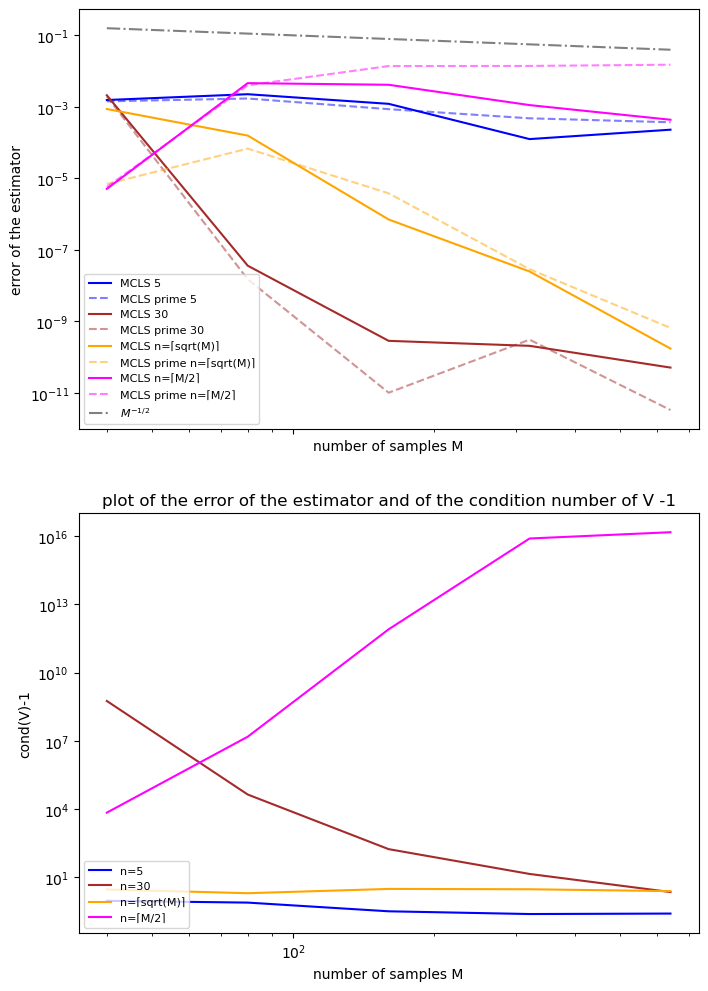

In [23]:
fig, ax = plt.subplots(2,figsize= (8,12), sharey = False, sharex = True)

N=[5, 30] #for reference/comparison to sqrt(M), M/2
M_array=np.array([20*2**i for i in range(1,6)]) #modify to (1,8) during the night??

seed_1=9009
seed_2=1991

sbplt_0 = ax[0] #plot of the estimators
sbplt_1 = ax[1] #plot of the condition number
c=['blue', 'brown']
for i, n in enumerate(N):
    error_function_IMCLS=[]
    error_function_IMCLS_prime=[]
    cond_V=[]
    
    for m in M_array:
        e_IMCLS, e_IMCLS_prime, c_v=IMCLS(m, n, seed_1, seed_2)
        cond_V.append(c_v-1)
        error_function_IMCLS.append(e_IMCLS)
        error_function_IMCLS_prime.append(e_IMCLS_prime)
  
    sbplt_0.loglog(M_array,error_function_IMCLS, color=c[i], label="MCLS "+str(n))
    sbplt_0.loglog(M_array,error_function_IMCLS_prime, alpha=0.5, color=c[i], linestyle='--', label="MCLS prime "+str(n))
    sbplt_1.loglog(M_array, cond_V, color=c[i], label='n='+str(n))
    sbplt_1.set_title("(Condition number of V)-1 versus the number of samples")
    

#doing the same for n=⌈sqrt(M)⌉ and n=⌈M/2⌉

N_func_1=lambda m: int(np.ceil(np.sqrt(m)))
N_func_2=lambda m: int(np.ceil(m/2))
err_sqrt_M=[]
err_sqrt_M_prime=[]
err_M_2=[]
err_M_2_prime=[]
cond_V_sqrt_M=[]
cond_V_M_2=[]

for m in M_array:
    e_sqrt_M, e_sqrt_M_prime, c_v_sqrt_M=IMCLS(m, N_func_1(m), seed_1, seed_2)
    
    e_M_2, e_M_2_prime, c_v_M_2=IMCLS(m, N_func_2(m), seed_1, seed_2)
    
    err_sqrt_M.append(e_sqrt_M)
    err_sqrt_M_prime.append(e_sqrt_M_prime)
    err_M_2.append(e_M_2)
    err_M_2_prime.append(e_M_2_prime)
    
    cond_V_sqrt_M.append(c_v_sqrt_M)
    cond_V_M_2.append(c_v_M_2)
    
    print(m, " doing with n depending on M")

sbplt_0.loglog(M_array, err_sqrt_M, color="orange", label='MCLS n=⌈sqrt(M)⌉')
sbplt_0.loglog(M_array, err_sqrt_M_prime, color="orange", linestyle='--', alpha=0.5, label='MCLS prime n=⌈sqrt(M)⌉')
sbplt_0.loglog(M_array, err_M_2, color="magenta", label='MCLS n=⌈M/2⌉')
sbplt_0.loglog(M_array, err_M_2_prime, color="magenta", linestyle='--', alpha=0.5, label='MCLS prime n=⌈M/2⌉')
sbplt_1.loglog(M_array, cond_V_sqrt_M, color="orange", label="n=⌈sqrt(M)⌉")
sbplt_1.loglog(M_array, cond_V_M_2, color="magenta", label="n=⌈M/2⌉")

#ploting O(M^{-1/2})
sbplt_0.loglog(M_array, M_array**-0.5, '-.',color='gray', label = r'$M^{-1/2}$')
        
sbplt_0.legend(loc='lower left', fontsize=8)
sbplt_0.set_xlabel("number of samples M")
sbplt_0.set_ylabel("error of the estimator")

sbplt_1.legend(loc='lower left', fontsize=8)
sbplt_1.set_xlabel("number of samples M")
sbplt_1.set_ylabel("cond(V)-1")

plt.title("plot of the error of the estimator and of the condition number of V -1")
plt.show()
        
fig.tight_layout()

#to save the figures separatly
extent_0 = sbplt_0.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_1 = sbplt_1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
sbplt_0.figure.savefig("Figures/MCLS_and_prime_fun_n.png", bbox_inches=extent_0.expanded(1.3, 1.12))
sbplt_1.figure.savefig("Figures/condition_number_fun_n.png", bbox_inches=extent_1.expanded(1.3, 1.12))